Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Start with Logistic model

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):  # force CPU-only usage  (bcos I have trouble w/ GPU memory)
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        beta             = tf.placeholder(tf.float32)  # Beta for Regularization
        
        # Variables 
        weights  = tf.Variable(
                    tf.truncated_normal([image_size * image_size, num_labels]))
        biases   = tf.Variable(tf.zeros([num_labels]))
        
        ## Training computation
        # logits = X . W + b
        logits = tf.matmul( tf_train_dataset, weights) + biases
        # loss is avg of {cross entropy for the logits + regularized weights}
        loss   = tf.reduce_mean( 
                    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + beta * tf.nn.l2_loss(weights)
        
        ## Optimizer
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        ## Predictions for training, validation and test 
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(
                            tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction  = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [8]:
num_steps = 3001

## For limiting GPU memory usage: -- Added by Atul
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: 1e-3 }
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 500 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %.1f%%" % accuracy(predictions, batch_labels))
            print("validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
minibatch loss at step 0: 17.342541
minibatch accuracy : 21.1%
validation accuracy: 18.0%
minibatch loss at step 500: 2.486070
minibatch accuracy : 82.0%
validation accuracy: 76.1%
minibatch loss at step 1000: 1.770455
minibatch accuracy : 78.1%
validation accuracy: 77.9%
minibatch loss at step 1500: 0.944515
minibatch accuracy : 84.4%
validation accuracy: 79.7%
minibatch loss at step 2000: 0.846611
minibatch accuracy : 86.7%
validation accuracy: 80.7%
minibatch loss at step 2500: 0.858664
minibatch accuracy : 81.2%
validation accuracy: 81.4%
minibatch loss at step 3000: 0.770286
minibatch accuracy : 85.2%
validation accuracy: 81.6%

Test accuracy: 88.8%


We dont know what is an optimum value of the Regularization param, so we could run the test with different values and see which gives the best accuracy


In [9]:
num_steps = 3001
params_regularization = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []

for R_param in params_regularization:
    with tf.Session(graph=graph, config=config) as session:
        tf.initialize_all_variables().run()
        print ("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a mini batch
            batch_data   = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels [offset:(offset + batch_size), :]
            # Make a dict telling the session where to find the minibatch
            feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: R_param }
            # Run the damn thing
            _, loss_step, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            # save the TEST accuracy only
        accuracy_values.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


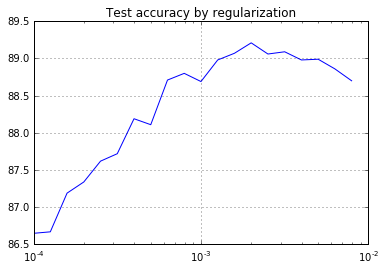

In [11]:
# let's plot the accuracy

import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(params_regularization, accuracy_values)
plt.grid(True)
plt.title('Test accuracy by regularization')
plt.show()

Let's try the technique with 2-layer network (1-hidden)

In [32]:
batch_size = 100
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        
        # Variables
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes, num_labels]))
        biases2  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        logits = tf.matmul(layer1_out, weights2) + biases2
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        # Preductions for training / validation / test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer1_validation, weights2) + biases2)
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction   = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)
        

In [34]:
num_steps = 3001


beta_fixed = 1e-3   # Testing with one value of Regularization param

## For limiting GPU memory usage: -- Added by Atul
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed }    # Regularization param from above
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 500 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %.1f%%" % accuracy(predictions, batch_labels))
            print("validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
minibatch loss at step 0: 663.689575
minibatch accuracy : 10.0%
validation accuracy: 29.5%
minibatch loss at step 500: 204.714737
minibatch accuracy : 77.0%
validation accuracy: 79.4%
minibatch loss at step 1000: 115.530586
minibatch accuracy : 75.0%
validation accuracy: 80.6%
minibatch loss at step 1500: 69.627472
minibatch accuracy : 76.0%
validation accuracy: 81.2%
minibatch loss at step 2000: 41.660244
minibatch accuracy : 77.0%
validation accuracy: 83.0%
minibatch loss at step 2500: 25.039907
minibatch accuracy : 90.0%
validation accuracy: 85.8%
minibatch loss at step 3000: 15.567118
minibatch accuracy : 85.0%
validation accuracy: 86.2%

Test accuracy: 93.1%


In [ ]:
Getting better. Let's try for different value of Regularization param

In [35]:
num_steps = 3001
params_regularization = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_values = []

for R_param in params_regularization:
    with tf.Session(graph=graph, config=config) as session:
        tf.initialize_all_variables().run()
        print ("Initialized for reg param: ", R_param)
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a mini batch
            batch_data   = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels [offset:(offset + batch_size), :]
            # Make a dict telling the session where to find the minibatch
            feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: R_param }
            # Run the damn thing
            _, loss_step, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            # save the TEST accuracy only
        accuracy_values.append(accuracy(test_prediction.eval(), test_labels))

Initialized for reg param:  0.0001
Initialized for reg param:  0.000125892541179
Initialized for reg param:  0.000158489319246
Initialized for reg param:  0.000199526231497
Initialized for reg param:  0.000251188643151
Initialized for reg param:  0.000316227766017
Initialized for reg param:  0.000398107170553
Initialized for reg param:  0.000501187233627
Initialized for reg param:  0.00063095734448
Initialized for reg param:  0.000794328234724
Initialized for reg param:  0.001
Initialized for reg param:  0.00125892541179
Initialized for reg param:  0.00158489319246
Initialized for reg param:  0.00199526231497
Initialized for reg param:  0.00251188643151
Initialized for reg param:  0.00316227766017
Initialized for reg param:  0.00398107170553
Initialized for reg param:  0.00501187233627
Initialized for reg param:  0.0063095734448
Initialized for reg param:  0.00794328234724


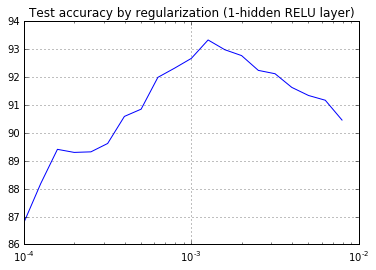

In [36]:
# Let's plot it
plt.semilogx(params_regularization, accuracy_values)
plt.grid(True)
plt.title('Test accuracy by regularization (1-hidden RELU layer)')
plt.show()

In [39]:
def myargmax(lst):
    return lst.index(max(lst))

maxindex = myargmax(accuracy_values)
print('index of max accuracy: ', maxindex)
print('max accuracy: ', accuracy_values[maxindex], ', reg param:', params_regularization[maxindex] )

index of max accuracy:  11
max accuracy:  93.33 , reg param: 0.00125892541179


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [40]:
## Let's define a 2-layer network with 1-hidden ReLU layer
batch_size = 100
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        
        # Variables
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes, num_labels]))
        biases2  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        logits = tf.matmul(layer1_out, weights2) + biases2
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        # Preductions for training / validation / test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer1_validation, weights2) + biases2)
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction   = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)


In [41]:
num_steps = 101   # few steps to show Overfitting
num_batches = 5   # Using small batches to show Overfitting


beta_fixed = 1e-3   # Testing with one value of Regularization param

## For limiting GPU memory usage: -- Added by Atul
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed }    # Regularization param from above
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 5 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %.1f%%" % accuracy(predictions, batch_labels))
            print("validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
minibatch loss at step 0: 733.867920
minibatch accuracy : 12.0%
validation accuracy: 29.5%
minibatch loss at step 5: 445.479431
minibatch accuracy : 82.0%
validation accuracy: 59.1%
minibatch loss at step 10: 311.561920
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 15: 310.007568
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 20: 308.461121
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 25: 306.922333
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 30: 305.391235
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 35: 303.867859
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 40: 302.351837
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 45: 300.843262
minibatch accuracy : 100.0%
validation accuracy: 58.8%
minibatch loss at step 50: 299.342682
minibatch accuracy : 100

As it shows, the generalization accuracy is terrible

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [46]:
## Let's intro a Dropout in Training
## Let's define a 2-layer network with 1-hidden ReLU layer
batch_size = 100
num_hidden_nodes = 1024
#dropout_percent = 0.5   # 50% dropout

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        keep_prob        = tf.placeholder(tf.float32)   # for Dropout
        
        # Variables
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes]))
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes, num_labels]))
        biases2  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation.... with Dropout
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        # Dropout some output of Layer 1... only on Training data!
        drop1      = tf.nn.dropout(layer1_out, keep_prob)
        logits     = tf.matmul(drop1, weights2) + biases2
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        # Preductions for training / validation / test; no Dropout on Validation/Test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer1_validation, weights2) + biases2)
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction   = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)


In [47]:
num_steps = 101   # few steps to show Overfitting
num_batches = 5   # Using small batches to show Overfitting

beta_fixed = 1e-3   # Testing with one value of Regularization param
keep_prob_val  = 0.5    # 50% dropout

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        # offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed,    # Reg param from above
                     keep_prob: keep_prob_val}    # dropout
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 5 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %.1f%%" % accuracy(predictions, batch_labels))
            print("validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
minibatch loss at step 0: 793.473877
minibatch accuracy : 10.0%
validation accuracy: 24.9%
minibatch loss at step 5: 349.102173
minibatch accuracy : 90.0%
validation accuracy: 59.6%
minibatch loss at step 10: 318.344818
minibatch accuracy : 96.0%
validation accuracy: 61.8%
minibatch loss at step 15: 312.235687
minibatch accuracy : 99.0%
validation accuracy: 65.7%
minibatch loss at step 20: 309.521851
minibatch accuracy : 100.0%
validation accuracy: 66.3%
minibatch loss at step 25: 309.919678
minibatch accuracy : 98.0%
validation accuracy: 65.4%
minibatch loss at step 30: 307.983002
minibatch accuracy : 99.0%
validation accuracy: 64.5%
minibatch loss at step 35: 305.733612
minibatch accuracy : 99.0%
validation accuracy: 64.6%
minibatch loss at step 40: 303.655579
minibatch accuracy : 99.0%
validation accuracy: 64.1%
minibatch loss at step 45: 301.962982
minibatch accuracy : 100.0%
validation accuracy: 64.0%
minibatch loss at step 50: 301.093658
minibatch accuracy : 99.0%
val

Gets better accuracy with some 50% Dropout... but still low bcos we did very few batches.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's try a deeper network with:
- 3 layers (2 hidden)
- Regularization
- Dropout

In [48]:
## Let's define a 3-layer network with 2-hidden ReLU layer
batch_size = 100
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
beta_fixed = 0.00125892541179   # Best Reg param we found. Or else just 1e-3

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        # Global Step
        global_step      = tf.Variable(0)
        
        # Variables
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes1],
                               stddev=np.sqrt(2.0 / (image_size*image_size)) )
        )
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes1]))
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2],
                               stddev=np.sqrt(2.0/num_hidden_nodes1))
        )
        biases2  = tf.Variable(tf.zeros([num_hidden_nodes2]))
        weights3 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes2, num_labels],
                               stddev=np.sqrt(2.0/num_hidden_nodes2))
            )
        biases3  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation - Layer1
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        # Layer 2
        layer2_out = tf.nn.relu(tf.matmul(layer1_out, weights2) + biases2)
        # Logits 
        logits = tf.matmul(layer2_out, weights3) + biases3
        # Loss
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        # Preductions for training / validation / test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        layer2_validation = tf.nn.relu(tf.matmul(layer1_validation, weights2) + biases2)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer2_validation, weights3) + biases3)
        
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        layer2_test       = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
        test_prediction   = tf.nn.softmax(tf.matmul(layer2_test, weights3) + biases3)


In [49]:
num_steps = 5001


beta_fixed = 1e-3   # Testing with one value of Regularization param

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized, with reg:", beta_fixed)
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed }    # Regularization param from above
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 500 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %.1f%%" % accuracy(predictions, batch_labels))
            print("validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized, with reg: 0.001
minibatch loss at step 0: 3.426083
minibatch accuracy : 7.0%
validation accuracy: 34.7%
minibatch loss at step 500: 1.262513
minibatch accuracy : 77.0%
validation accuracy: 85.0%
minibatch loss at step 1000: 1.025840
minibatch accuracy : 80.0%
validation accuracy: 86.4%
minibatch loss at step 1500: 0.906518
minibatch accuracy : 81.0%
validation accuracy: 86.6%
minibatch loss at step 2000: 0.691344
minibatch accuracy : 86.0%
validation accuracy: 87.6%
minibatch loss at step 2500: 0.400855
minibatch accuracy : 94.0%
validation accuracy: 87.4%
minibatch loss at step 3000: 0.623376
minibatch accuracy : 89.0%
validation accuracy: 87.7%
minibatch loss at step 3500: 0.525751
minibatch accuracy : 90.0%
validation accuracy: 88.3%
minibatch loss at step 4000: 0.481462
minibatch accuracy : 90.0%
validation accuracy: 87.5%
minibatch loss at step 4500: 0.514146
minibatch accuracy : 86.0%
validation accuracy: 87.7%
minibatch loss at step 5000: 0.487243
minibatch accuracy

Already gotten good results. Let's try another layer, with Dropout now

In [50]:
## Let's try a larger network

## Let's define a 4-layer network with 3-hidden ReLU layer
batch_size = 100
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256
beta_fixed = 0.00125892541179   # Best Reg param we found. Or else just 1e-3

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        # Global Step
        global_step      = tf.Variable(0)
        
        ## Variables
        # layer1
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes1],
                               stddev=np.sqrt(2.0 / (image_size*image_size)) )
        )
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes1]))
        # layer2
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2],
                               stddev=np.sqrt(2.0/num_hidden_nodes1))
        )
        biases2  = tf.Variable(tf.zeros([num_hidden_nodes2]))
        # layer3
        weights3 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3],
                               stddev=np.sqrt(2.0/num_hidden_nodes2))
            )
        biases3  = tf.Variable(tf.zeros([num_hidden_nodes3]))
        # layer4
        weights4 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes3, num_labels],
                               stddev=np.sqrt(2.0/num_hidden_nodes3))
            )
        biases4  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation - Layer1
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        # Layer 2
        layer2_out = tf.nn.relu(tf.matmul(layer1_out, weights2) + biases2)
        # Layer 3
        layer3_out = tf.nn.relu(tf.matmul(layer2_out, weights3) + biases3)
        # Logits 
        logits = tf.matmul(layer3_out, weights4) + biases4
        # Loss
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))
        
        # Optimizer, with Learning Rate schedule
        learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        
        # Preductions for training / validation / test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        layer2_validation = tf.nn.relu(tf.matmul(layer1_validation, weights2) + biases2)
        layer3_validation = tf.nn.relu(tf.matmul(layer2_validation, weights3) + biases3)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer3_validation, weights4) + biases4)
        
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        layer2_test       = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
        layer3_test       = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
        test_prediction   = tf.nn.softmax(tf.matmul(layer3_test, weights4) + biases4)


In [51]:
## Train and run the network
num_steps = 15001

beta_fixed = 1e-3   # Testing with one value of Regularization param

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized, with reg:", beta_fixed)
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed }    # Regularization param from above
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress
        if (step % 500 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            print("minibatch accuracy : %g" % accuracy(predictions, batch_labels))
            print("validation accuracy: %g" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %g" % accuracy(test_prediction.eval(), test_labels))

Initialized, with reg: 0.001
minibatch loss at step 0: 3.721385
minibatch accuracy : 13
validation accuracy: 19.7
minibatch loss at step 500: 1.494225
minibatch accuracy : 80
validation accuracy: 84.63
minibatch loss at step 1000: 1.156099
minibatch accuracy : 83
validation accuracy: 86.77
minibatch loss at step 1500: 1.025510
minibatch accuracy : 80
validation accuracy: 86.41
minibatch loss at step 2000: 0.738874
minibatch accuracy : 89
validation accuracy: 86.99
minibatch loss at step 2500: 0.457955
minibatch accuracy : 93
validation accuracy: 87.34
minibatch loss at step 3000: 0.639746
minibatch accuracy : 89
validation accuracy: 87.59
minibatch loss at step 3500: 0.557891
minibatch accuracy : 87
validation accuracy: 88.26
minibatch loss at step 4000: 0.527442
minibatch accuracy : 88
validation accuracy: 87.48
minibatch loss at step 4500: 0.543994
minibatch accuracy : 87
validation accuracy: 87.68
minibatch loss at step 5000: 0.484738
minibatch accuracy : 93
validation accuracy: 88.

Let's try yet another - this time with Dropout


In [73]:
## Let's try a larger network

## Let's define a 4-layer network with 3-hidden ReLU layer
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 128
beta_fixed = 0.00125892541179   # Best Reg param we found. Or else just 1e-3

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # for force CPU only (as my GPU mem was not enough)
        # Input data
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        # Beta for Regularization
        beta             = tf.placeholder(tf.float32)
        # Global Step
        global_step      = tf.Variable(0)
        keep_prob        = tf.placeholder(tf.float32)   # for Dropout
        
        ## Variables
        # layer1
        weights1 = tf.Variable( 
            tf.truncated_normal([image_size*image_size, num_hidden_nodes1],
                               stddev=np.sqrt(2.0 / (image_size*image_size)) )
        )
        biases1  = tf.Variable(tf.zeros([num_hidden_nodes1]))
        # layer2
        weights2 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2],
                               stddev=np.sqrt(2.0/num_hidden_nodes1))
        )
        biases2  = tf.Variable(tf.zeros([num_hidden_nodes2]))
        # layer3
        weights3 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3],
                               stddev=np.sqrt(2.0/num_hidden_nodes2))
            )
        biases3  = tf.Variable(tf.zeros([num_hidden_nodes3]))
        # layer4
        weights4 = tf.Variable(
            tf.truncated_normal([num_hidden_nodes3, num_labels],
                               stddev=np.sqrt(2.0/num_hidden_nodes3))
            )
        biases4  = tf.Variable(tf.zeros([num_labels]))
        
        # Training computation - Layer1
        layer1_out = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        drop1      = tf.nn.dropout(layer1_out, keep_prob)   # Dropout 1
        # Layer 2
        layer2_out = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
        drop2      = tf.nn.dropout(layer2_out, keep_prob)   # Dropout 2
        # Layer 3
        layer3_out = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
        drop3      = tf.nn.dropout(layer3_out, keep_prob)   # Dropout 2
        # Logits 
        logits = tf.matmul(drop3, weights4) + biases4
        # Loss
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
            beta * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4))
        
        # Optimizer, with Learning Rate schedule
        learning_rate = tf.train.exponential_decay(0.5, global_step, 2000, 0.7, staircase=False)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        
        # Preductions for training / validation / test
        train_prediction  = tf.nn.softmax(logits)
        layer1_validation = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        layer2_validation = tf.nn.relu(tf.matmul(layer1_validation, weights2) + biases2)
        layer3_validation = tf.nn.relu(tf.matmul(layer2_validation, weights3) + biases3)
        valid_prediction  = tf.nn.softmax(tf.matmul(layer3_validation, weights4) + biases4)
        
        layer1_test       = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        layer2_test       = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
        layer3_test       = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
        test_prediction   = tf.nn.softmax(tf.matmul(layer3_test, weights4) + biases4)


In [74]:
## Train and run the network
num_steps = 10001

beta_fixed = 1e-3   # Testing with one value of Regularization param
keep_prob_val = 0.5 # Dropout percentage

step_vals = []   # step number store
test_acc_vals = []  # Test accuracy store
val_acc_vals  = []  # Validation acc store

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph, config=config) as session:
    tf.initialize_all_variables().run()
    print ("Initialized, with reg:", beta_fixed)
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = { tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed,            # Regul param
                     keep_prob: keep_prob_val}    # Dropout from above
        # Run the damn thing
        _, loss_step, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        # show progress  
        if (step % 500 == 0):
            print("minibatch loss at step %d: %f" % (step, loss_step))
            val_acc  = accuracy(valid_prediction.eval(), valid_labels)
            test_acc = accuracy(test_prediction.eval(), test_labels)
            print("minibatch accuracy : %g" % accuracy(predictions, batch_labels))
            print("validation accuracy: %g" % val_acc)
            step_vals.append(step)
            val_acc_vals.append(val_acc)
            test_acc_vals.append(test_acc)
            
    print("\nTest accuracy: %g" % test_acc)

Initialized, with reg: 0.001
minibatch loss at step 0: 4.007266
minibatch accuracy : 9.375
validation accuracy: 15.58
minibatch loss at step 500: 1.385044
minibatch accuracy : 85.9375
validation accuracy: 83.95
minibatch loss at step 1000: 1.159193
minibatch accuracy : 85.1562
validation accuracy: 84.91
minibatch loss at step 1500: 0.814913
minibatch accuracy : 88.2812
validation accuracy: 85.53
minibatch loss at step 2000: 0.694715
minibatch accuracy : 91.4062
validation accuracy: 85.64
minibatch loss at step 2500: 0.679360
minibatch accuracy : 86.7188
validation accuracy: 86.5
minibatch loss at step 3000: 0.749631
minibatch accuracy : 85.9375
validation accuracy: 85.91
minibatch loss at step 3500: 0.733149
minibatch accuracy : 82.0312
validation accuracy: 86.51
minibatch loss at step 4000: 0.630454
minibatch accuracy : 88.2812
validation accuracy: 86.51
minibatch loss at step 4500: 0.604914
minibatch accuracy : 87.5
validation accuracy: 86.44
minibatch loss at step 5000: 0.650062
min

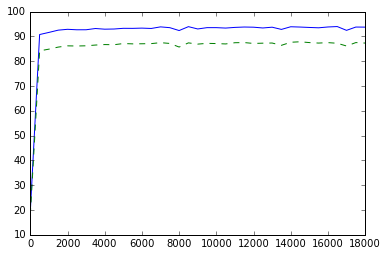

In [61]:
# Try plotting
plt.plot(step_vals, test_acc_vals, '-')
plt.plot(step_vals, val_acc_vals, '--')
plt.show()

In [62]:
m = myargmax(test_acc_vals)
print('max test: ', test_acc_vals[m])

max test:  93.97
